In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns
import nltk

## Reading in the Data

In [2]:
df = pd.read_csv('./Reviews.csv').head(500)
df['Text'][0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

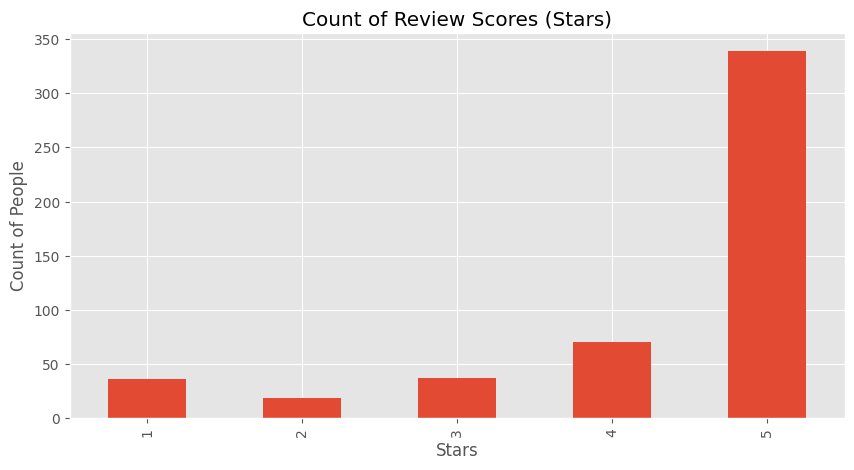

In [3]:
# Getting the 1-5 star rating score counts
review_scores_plot = df['Score'].value_counts().sort_index().plot(
    kind = 'bar',
    title='Count of Review Scores (Stars)',
    figsize=(10, 5)
)

review_scores_plot.set_xlabel('Stars')
review_scores_plot.set_ylabel('Count of People')
plt.show(review_scores_plot)


## Basic NLTK Primer

In [4]:
example_review = df['Text'][50]
print(example_review)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [5]:
tokens = nltk.word_tokenize(example_review)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [6]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [7]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## Using the VADER (bag-o-words) Model

In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [9]:
sia = SentimentIntensityAnalyzer()

In [10]:
#Testing out the sentiment analysis
sia.polarity_scores('I am very happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [11]:
sia.polarity_scores('This was very difficult')

{'neg': 0.482, 'neu': 0.518, 'pos': 0.0, 'compound': -0.4201}

In [12]:
print(example_review)
sia.polarity_scores(example_review)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

### Running VADER analysis on the entire subset of data

In [13]:
results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    _id  = row['Id']
    results[_id] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [14]:
vaders = pd.DataFrame(results).T
vaders.index.name = 'Id'
vaders.reset_index().rename(columns={'index': 'Id'})
vaders.head()

,neg,neu,pos,compound
Id,,,,
1,0.000,0.695,0.305,0.9441
2,0.138,0.862,0.000,-0.5664
3,0.091,0.754,0.155,0.8265
4,0.000,1.000,0.000,0.0000
5,0.000,0.552,0.448,0.9468


In [15]:
vaders = pd.merge(vaders, df, left_index=True, right_on='Id')
vaders.drop('Id', axis=1)
vaders.head()

,neg,neu,pos,compound,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0.000,0.695,0.305,0.9441,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,0.138,0.862,0.000,-0.5664,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,0.091,0.754,0.155,0.8265,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,0.000,1.000,0.000,0.0000,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,0.000,0.552,0.448,0.9468,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


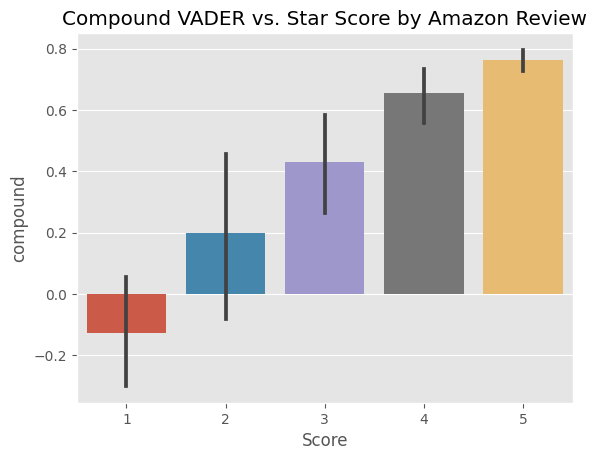

In [16]:
score_vader_barplot = sns.barplot(data=vaders, x='Score', y='compound')
score_vader_barplot.set_title('Compound VADER vs. Star Score by Amazon Review')
plt.show(score_vader_barplot)

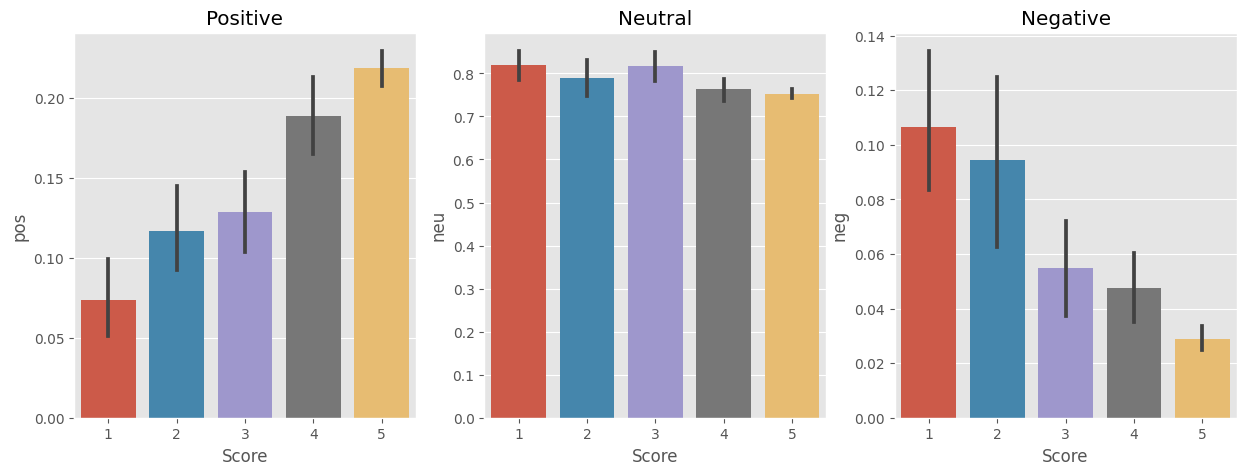

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show(fig)


## Using Roberta (Pretrained, Contextual) Model

Transformer, deep-learning, from Huggingface

In [18]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"  # trying to get GPU-run working

from scipy.special import softmax

In [19]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model = model.to(device)

In [20]:
print(example_review)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [21]:
# Encoding the text
encoded_text = tokenizer(example_review, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}
scores_dict

{'roberta_neg': 0.97635514,
 'roberta_neu': 0.02068747,
 'roberta_pos': 0.0029573706}

In [22]:
def polarity_scores_roberta(review_text):
    encoded_text = tokenizer(review_text, return_tensors='pt').to(device)
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }

In [23]:
polarity_scores_roberta(example_review)

{'roberta_neg': 0.97635514,
 'roberta_neu': 0.02068747,
 'roberta_pos': 0.0029573706}

### COmbining the Roberta and VADER Analysis

In [24]:
results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        _id = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result = {f'vader_{key}': value for key, value in vader_result.items()}
        roberta_result = polarity_scores_roberta(text)
        results[_id] = roberta_result | vader_result
    except RuntimeError:
        print(f'Roberta was unable to analyze for id {_id}')
list(results.items())[:5]

  0%|          | 0/500 [00:00<?, ?it/s]

Roberta was unable to analyze for id 83
Roberta was unable to analyze for id 187


[(1,
  {'roberta_neg': 0.009624231,
   'roberta_neu': 0.049980372,
   'roberta_pos': 0.94039536,
   'vader_neg': 0.0,
   'vader_neu': 0.695,
   'vader_pos': 0.305,
   'vader_compound': 0.9441}),
 (2,
  {'roberta_neg': 0.50898594,
   'roberta_neu': 0.4524137,
   'roberta_pos': 0.038600374,
   'vader_neg': 0.138,
   'vader_neu': 0.862,
   'vader_pos': 0.0,
   'vader_compound': -0.5664}),
 (3,
  {'roberta_neg': 0.003228903,
   'roberta_neu': 0.09806744,
   'roberta_pos': 0.8987037,
   'vader_neg': 0.091,
   'vader_neu': 0.754,
   'vader_pos': 0.155,
   'vader_compound': 0.8265}),
 (4,
  {'roberta_neg': 0.002295128,
   'roberta_neu': 0.09021924,
   'roberta_pos': 0.9074856,
   'vader_neg': 0.0,
   'vader_neu': 1.0,
   'vader_pos': 0.0,
   'vader_compound': 0.0}),
 (5,
  {'roberta_neg': 0.0016347283,
   'roberta_neu': 0.01030247,
   'roberta_pos': 0.98806286,
   'vader_neg': 0.0,
   'vader_neu': 0.552,
   'vader_pos': 0.448,
   'vader_compound': 0.9468})]

In [25]:
df['Text'][82]

'I know the product title says Molecular Gastronomy, but don\'t let that scare you off.  I have been looking for this for a while now, not for food science, but for something more down to earth.  I use it to make my own coffee creamer.<br /><br />I have to have my coffee blonde and sweet - but the flavored creamers are full of the bad kinds of fat, and honestly, I hate to use manufactured "food" items.  I really don\'t think they are good for the body.  On the other hand, I hate using cold milk or cream, because I like HOT coffee.<br /><br />I stumbled across this on Amazon one day and got the idea of making my own creamer.  I also bought low-fat (non-instant) milk powder and regular milk powder. The non-instant lowfat milk is a little sweeter and tastes fresher than regular instant low-fat milk, but does not dissolve good in cold water - which is not a problem for hot coffee.  You will have to play with the ratios - I would not do just the heavy cream, it made the coffee too rich. Als

In [27]:
device

'cpu'